In [1]:
import time
from options.train_options import TrainOptions
from model.model_Loader import CreatModel_test
from utils.utils import error

import tqdm
import os
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from data.data_loader import CreateDataLoader_test
from model.Component import one_hot_long, Tensor2Image
from torch.autograd import Variable

from PIL import Image

In [2]:
epoch = 200
opt = TrainOptions().parse()
data_loader_test = CreateDataLoader_test(opt)
model = CreatModel_test(opt, epoch)

D_interval: 1
G_interval: 1
N_expr: 6
batchsize: 64
beta1: 0.5
beta2: 0.999
checkpoints_dir: /home/wpk/paper/code/Comparison_experiments/ExprGAN/checkpoints/
count_epoch: 1
epochs: 1001
fm_coeff: 1
gpu_ids: [6]
input_nc: 3
is_Train: True
load_epoch: 0
lr: 0.0002
model: single
output_nc: 3
pretrained_D: None
pretrained_G: None
q_coeff: 1
save_epoch_freq: 50
test_checkpoints_dir: /home/wpk/paper/code/Comparison_experiments/ExprGAN/checkpoints
test_dir: ./result/2020-04-18_16-05-47
vgg_coeff: 1
Pretrain models were loaded, epoch is 200
model ExprGAN was created


In [3]:
model.Encoder.eval()
model.Decoder.eval()

for i, data in tqdm.tqdm(enumerate(data_loader_test)):
    if i>=30:
        break
    input_image = []
    for k in data[0]:
        input_image.append(k)
    input_image = torch.stack(input_image, dim = 0)
    input_image = input_image.cuda()
    input_image = Variable(input_image)
    for j in range(0, 6):
        batch_expr = torch.LongTensor([j])
        batch_expr = batch_expr.cuda()  
        batch_expr = Variable(batch_expr)
        
        img = input_image.data[0]
        img = Tensor2Image(img)
        
        width, height = img.size
        result_img = Image.new(img.mode, (width*11, height))
        result_img.paste(img, (0, 0, width, height))
        
#         expr_dict = {0: 'Disgust',
#                     1: 'Neutral',
#                     2: 'Scream',
#                     3: 'Smile',
#                     4: 'Squint',
#                     5: 'Surprise'}
        expr_dict = {0: 'Angry',
                    1: 'Disgust',
                    2: 'Fearful',
                    3: 'Happy',
                    4: 'Sad',
                    5: 'Surprise'}
        filename = 'image_' + str(i) + '_' + expr_dict[int(j)] + '.png'
        path = os.path.join('/home/wpk/paper/code/Comparison_experiments/ExprGAN/final2paper', filename)
        
        index = 1
        for intensity in range(1, 11):# intensity
            batch_expr_long = one_hot_long(batch_expr, 6, intensity*0.5)
            batch_expr_long = batch_expr_long.cuda()
            batch_expr_long = Variable(batch_expr_long)

            # --------- 测试 -------------
            z = model.Encoder(input_image)
            G = model.Decoder(z, batch_expr_long)

            # ---------- 保存结果 -------------
            
            syn_img = G.data[0]
            syn_img = Tensor2Image(syn_img)
            result_img.paste(syn_img, (width*index, 0))
            index += 1
        result_img.save(path, quality=95)

30it [01:22,  2.66s/it]


300


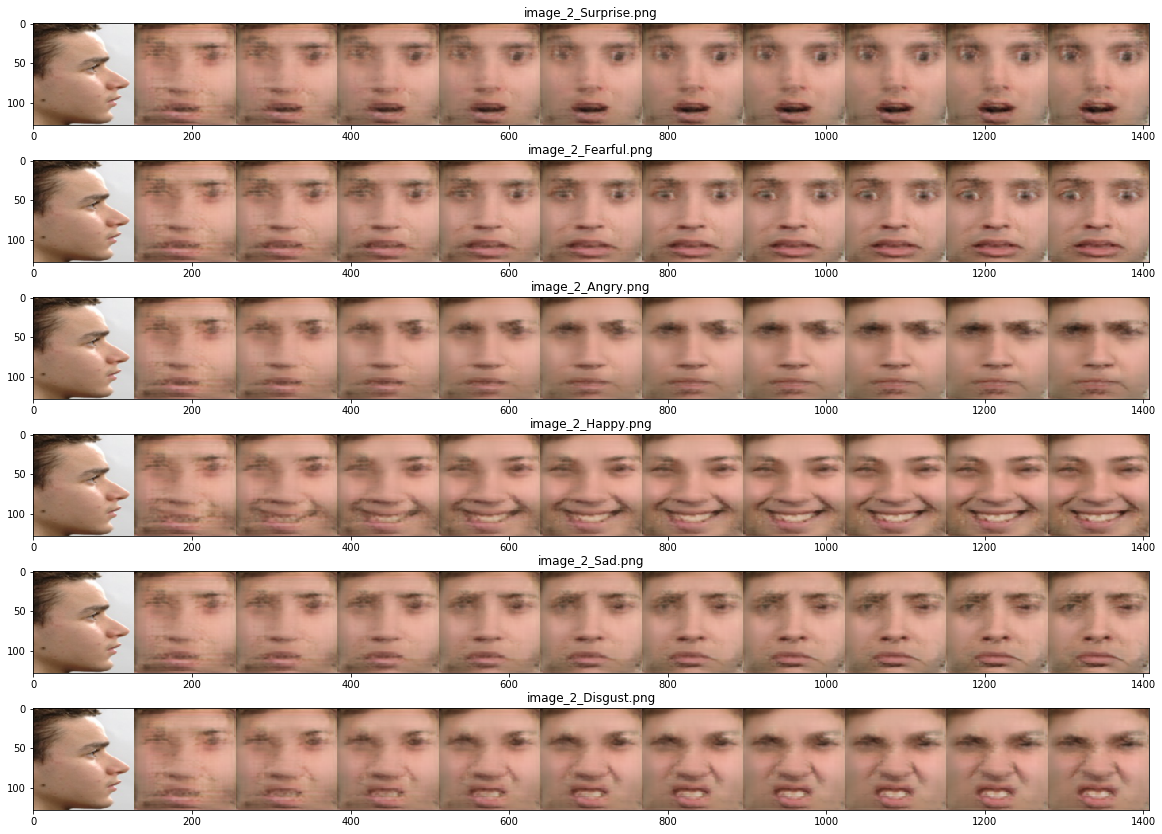

In [4]:
show_path = '/home/wpk/paper/code/Comparison_experiments/ExprGAN/final2paper'
name_list = os.listdir(show_path)
# name_list.sort()
plt.figure(figsize=(20,50))
index = 1
print(len(name_list))
for i in range(len(name_list)):
    if 'image_2_' in name_list[i]:
        image_dst = Image.open(os.path.join(show_path, name_list[i])) 
        plt.subplot(20, 1, index)
        plt.title(name_list[i])
        plt.imshow(image_dst)

        index += 1
plt.show()